In [1]:
import os
from google.cloud import storage
from matplotlib import pyplot as plt
import numpy as np
import sys

In [32]:
from time import sleep

def get_item_data(item, N, seed, program, env):
    lst = list()
    if not os.path.isdir(f"./output/{env}"):
        os.system(f"mkdir ./output/{env}")
    if not os.path.isdir(f"./output/{env}/{program}"):
        os.system(f"mkdir ./output/{env}/{program}")
    bucket = storage.Client().bucket('kiran-research')
    for n in range(N):
        try:
            blob = bucket.blob(f"latent-actions/outputs/{program}/seed{seed + n}/{env}/{item}.npy")
            blob.download_to_filename(f"./output/{env}/{program}/{seed + n}/{item}.npy")
            lst.append(np.load(f"./output/{env}/{program}/{seed + n}/{item}.npy"))
        except:
            lst.append(np.array([]))
    print(f"from {program}/{env}: {[min(l.size, l.shape[0]) for l in lst]}")
    length = min([min(l.size, l.shape[0]) for l in lst])
    print(f"num timesteps in array: {length}")
    arr = np.concatenate([l[np.newaxis, :length, ...] for l in lst], axis=0)
    return arr

In [33]:
default_colors = ["blue"]
def show_programs_and_envs(item, 
                           programs, 
                           envs, 
                           datasets, 
                           seed, 
                           N=5, 
                           eval_freq=int(5e3), 
                           max_timesteps=int(1e6), 
                           colors=default_colors,
                           aux=None):
    fig, axes = plt.subplots(ncols=len(envs), nrows=len(datasets), figsize=(20, 20))
    if len(envs) > 1:
        for ax, col in zip(axes[0], envs):
            ax.set_title(col)
    else:
        axes[0].set_title(envs[0])
    if len(envs) > 1:
        for ax, row in zip(axes[:,0], datasets):
            ax.set_ylabel(row, size='large')
    else:
        for ax, row in zip(axes, datasets):
            ax.set_ylabel(row, size='large')
    assert len(colors) >= len(programs)
    for i, env in enumerate(envs):
        for j, dataset in enumerate(datasets):
            for k, program in enumerate(programs):
                index = i * len(datasets) + j + 1
                rewards = get_item_data(item, N, seed, program, env + "-" + dataset)
                mean = rewards.mean(0)
                std = rewards.std(0)
                x = range(eval_freq, eval_freq * (mean.shape[0] + 1), eval_freq)
                if len(envs) > 1 and len(datasets) > 1:
                    axes[j, i].set_ylim(0, 1.2)
                    axes[j, i].plot(x, mean, color=colors[k], label=program)
                    axes[j, i].fill_between(x, mean - 2 * std, mean + 2 * std, facecolor=colors[k], alpha=0.2)
                    if aux is not None and i < 3 and j != 2:
                        axes[j, i].hlines(aux[i][j] / 100., 0, eval_freq * (mean.shape[0] + 1), colors=['red'])
                elif len(envs) > 1:
                    axes[i].set_ylim(0, 1.2)
                    axes[i].plot(x, mean, color=colors[k], label=program)
                    axes[i].fill_between(x, mean - 2 * std, mean + 2 * std, facecolor=colors[k], alpha=0.2)
                    if aux is not None and i < 3 and j != 2:
                        axes[i].hlines(aux[i][j] / 100., 0, eval_freq * (mean.shape[0] + 1), colors=['red'])
                elif len(datasets) > 1:
                    axes[j].set_ylim(0, 1.2)
                    axes[j].plot(x, mean, color=colors[k], label=program)
                    axes[j].fill_between(x, mean - 2 * std, mean + 2 * std, facecolor=colors[k], alpha=0.2)
                    if aux is not None and i < 3 and j != 2:
                        axes[j].hlines(aux[i][j] / 100., 0, eval_freq * (mean.shape[0] + 1), colors=['red'])
                
    plt.legend()
    plt.show()

In [ ]:
envs = ["halfcheetah", "walker2d", "hopper", "ant"]
datasets = ["random-v0", "medium-v0", "expert-v0", "medium-replay-v0", "medium-expert-v0"]
aux = [[2.2, 40.7, None, 38.2, 64.7], [4.9, 53.1, None, 15.0, 57.5], [10.6, 54.5, None, 33.1, 110.9]]
show_programs_and_envs("reward", ['bcq'], envs, datasets, 1980, aux=aux)

from ours/halfcheetah-random-v0: [72]
num timesteps in array: 72
from ours/halfcheetah-random-v0: [3]
num timesteps in array: 3
from ours/halfcheetah-random-v0: [38]
num timesteps in array: 38
from ours/halfcheetah-random-v0: [73]
num timesteps in array: 73
from ours/halfcheetah-random-v0: [75]
num timesteps in array: 75
from ours/halfcheetah-medium-v0: [78]
num timesteps in array: 78
from ours/halfcheetah-medium-v0: [76]
num timesteps in array: 76
from ours/halfcheetah-medium-v0: [77]
num timesteps in array: 77
from ours/halfcheetah-medium-v0: [78]
num timesteps in array: 78
from ours/halfcheetah-medium-v0: [75]
num timesteps in array: 75
from ours/halfcheetah-expert-v0: [75]
num timesteps in array: 75
from ours/halfcheetah-expert-v0: [79]
num timesteps in array: 79
from ours/halfcheetah-expert-v0: [74]
num timesteps in array: 74
from ours/halfcheetah-expert-v0: [74]
num timesteps in array: 74
from ours/halfcheetah-expert-v0: [77]
num timesteps in array: 77
from ours/halfcheetah-mediu

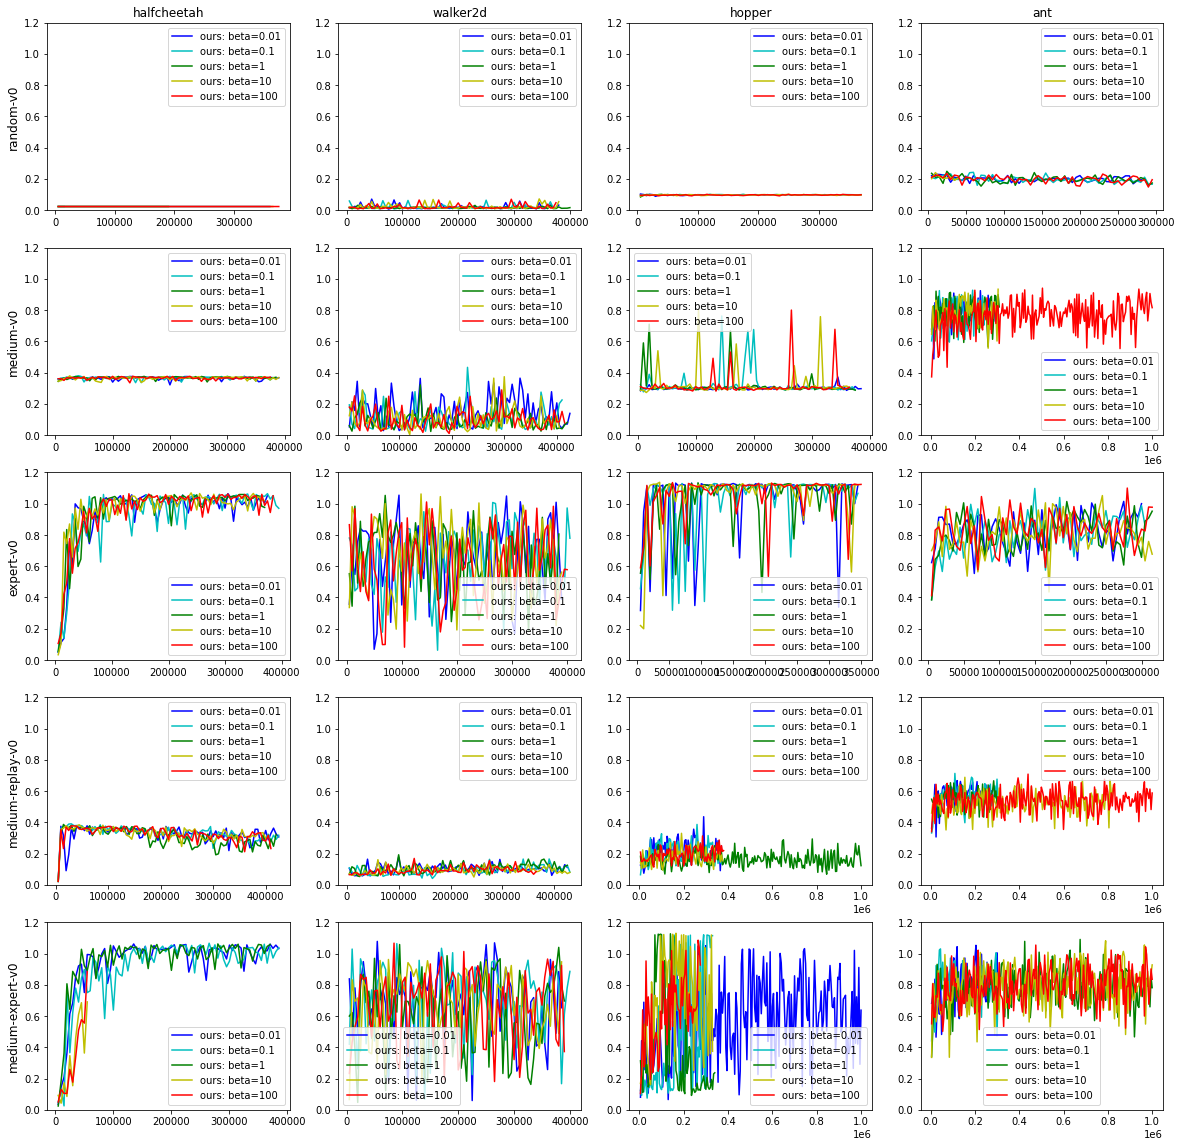

In [29]:
def show_hyperparam_sweep(item, 
                          programs,
                          envs,
                          datasets,
                          hp_mapping,
                          colors,
                          ymin=None,
                          ymax=None,
                          N=1,
                          eval_freq=int(5e3), 
                          max_timesteps=int(1e6), 
                          aux=None,
                          smoothing=1):
    fig, axes = plt.subplots(ncols=len(envs), nrows=len(datasets), figsize=(20, 20))
    for ax, col in zip(axes[0], envs):
        ax.set_title(col)
    for ax, row in zip(axes[:,0], datasets):
        ax.set_ylabel(row, size='large')
    assert len(colors) >= len(programs)
    for i, env in enumerate(envs):
        for j, dataset in enumerate(datasets):
            for program in programs:
                for s, seed in hp_mapping[program].items():
                    index = i * len(datasets) + j + 1
                    rewards = get_item_data(item, N, seed, program, env + "-" + dataset)
                    mean = rewards.mean(0)
                    std = rewards.std(0)
                    x = range(eval_freq, eval_freq * (mean.shape[0] + 1), eval_freq)
                    if not (ymin is None or ymax is None):
                        axes[j, i].set_ylim(ymin, ymax)
                    axes[j, i].fill_between(x, mean - std, mean + std, facecolor=colors[program][s], alpha=0.2)
                    axes[j, i].plot(x, mean, c=colors[program][s], label=program + ": " + s if s != "" else s)
                    if aux is not None and i < 3 and j != 2:
                        axes[j, i].hlines(aux[i][j] / 100., 0, eval_freq * (mean.shape[0] + 1), colors=['r'])
                    axes[j, i].legend()
    plt.show()
envs = ["halfcheetah", "walker2d", "hopper", "ant"]
datasets = ["random-v0", "medium-v0", "expert-v0", "medium-replay-v0", "medium-expert-v0"]
hp_mapping = {'ours': {'beta=0.01': 1980, 'beta=0.1': 1981, 'beta=1': 1982, 'beta=10': 1983, 'beta=100':1984}}
colors = {'ours': {'beta=0.01': 'b', 'beta=0.1': 'c', 'beta=1': 'g', 'beta=10': 'y', 'beta=100': 'r'}}
show_hyperparam_sweep("reward", ['ours'], envs, datasets, hp_mapping, colors, ymin=0, ymax=1.2)

from ours/halfcheetah-random-v0: [250000]
num timesteps in array: 250000
from ours/halfcheetah-random-v0: [15000]
num timesteps in array: 15000
from ours/halfcheetah-random-v0: [190000]
num timesteps in array: 190000
from ours/halfcheetah-random-v0: [260000]
num timesteps in array: 260000
from ours/halfcheetah-random-v0: [265000]
num timesteps in array: 265000
from ours/halfcheetah-medium-v0: [275000]
num timesteps in array: 275000
from ours/halfcheetah-medium-v0: [270000]
num timesteps in array: 270000
from ours/halfcheetah-medium-v0: [270000]
num timesteps in array: 270000
from ours/halfcheetah-medium-v0: [275000]
num timesteps in array: 275000
from ours/halfcheetah-medium-v0: [265000]
num timesteps in array: 265000
from ours/halfcheetah-expert-v0: [265000]
num timesteps in array: 265000
from ours/halfcheetah-expert-v0: [275000]
num timesteps in array: 275000
from ours/halfcheetah-expert-v0: [260000]
num timesteps in array: 260000
from ours/halfcheetah-expert-v0: [260000]
num timeste

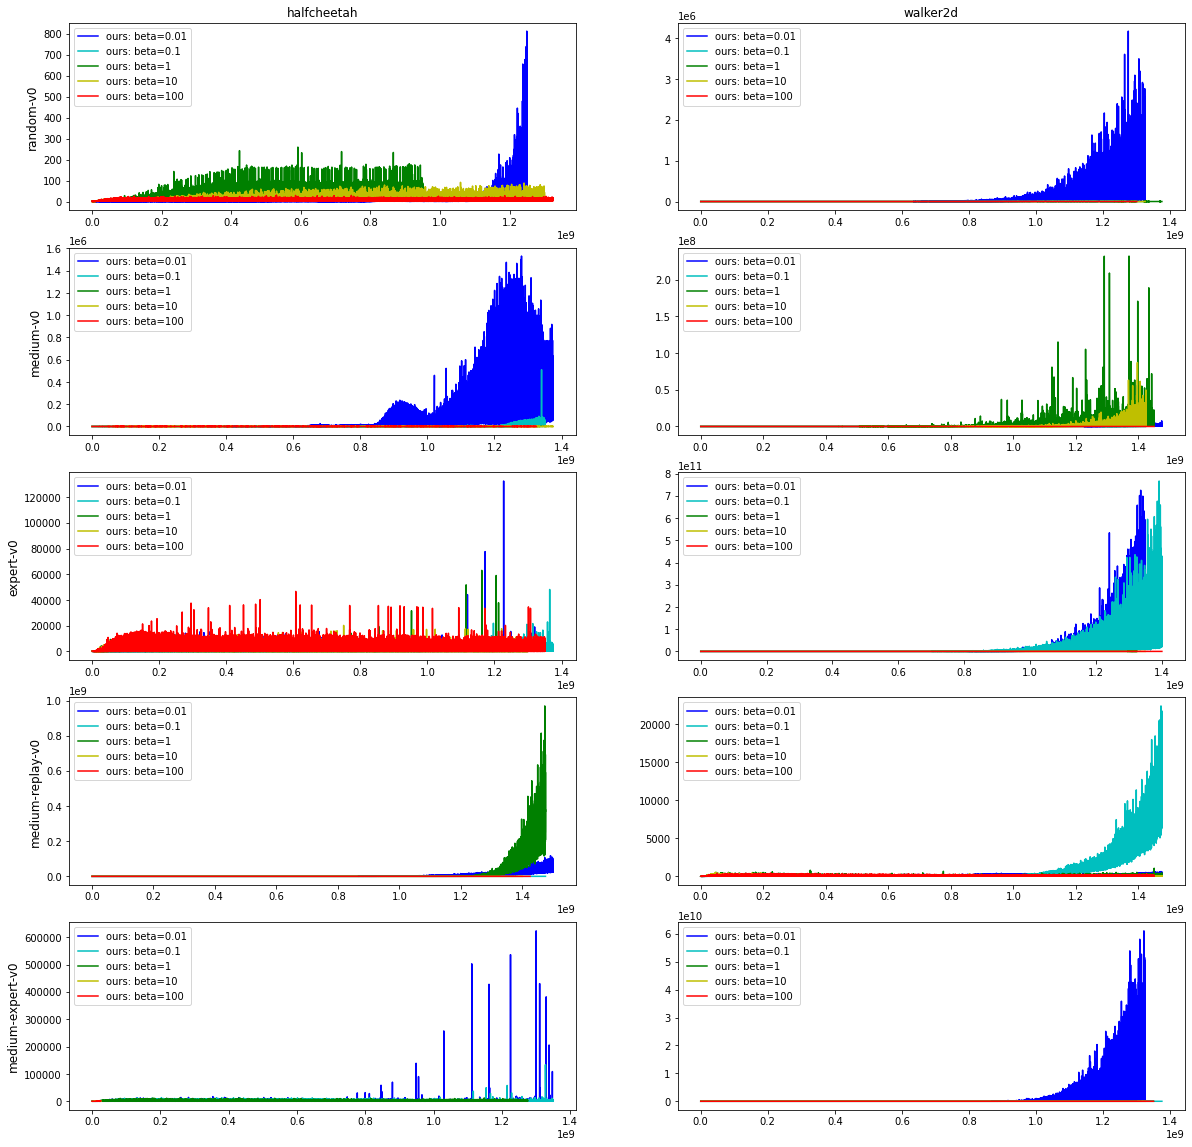

In [16]:
show_hyperparam_sweep("critic_loss", ['ours'], ['halfcheetah', 'walker2d'], datasets, hp_mapping, colors)

from ours/halfcheetah-random-v0: [255000]
num timesteps in array: 255000
from ours/halfcheetah-random-v0: [15000]
num timesteps in array: 15000
from ours/halfcheetah-random-v0: [190000]
num timesteps in array: 190000
from ours/halfcheetah-random-v0: [260000]
num timesteps in array: 260000
from ours/halfcheetah-random-v0: [265000]
num timesteps in array: 265000
from ours/halfcheetah-medium-v0: [275000]
num timesteps in array: 275000
from ours/halfcheetah-medium-v0: [270000]
num timesteps in array: 270000
from ours/halfcheetah-medium-v0: [270000]
num timesteps in array: 270000
from ours/halfcheetah-medium-v0: [275000]
num timesteps in array: 275000
from ours/halfcheetah-medium-v0: [265000]
num timesteps in array: 265000
from ours/halfcheetah-expert-v0: [265000]
num timesteps in array: 265000
from ours/halfcheetah-expert-v0: [275000]
num timesteps in array: 275000
from ours/halfcheetah-expert-v0: [260000]
num timesteps in array: 260000
from ours/halfcheetah-expert-v0: [260000]
num timeste

NotFound: 404 GET https://storage.googleapis.com/download/storage/v1/b/kiran-research/o/latent-actions%2Foutputs%2Fours%2Fseed1983%2Fhalfcheetah-medium-expert-v0%2Fcritic_kl_loss.npy?alt=media: No such object: kiran-research/latent-actions/outputs/ours/seed1983/halfcheetah-medium-expert-v0/critic_kl_loss.npy: ('Request failed with status code', 404, 'Expected one of', <HTTPStatus.OK: 200>, <HTTPStatus.PARTIAL_CONTENT: 206>)

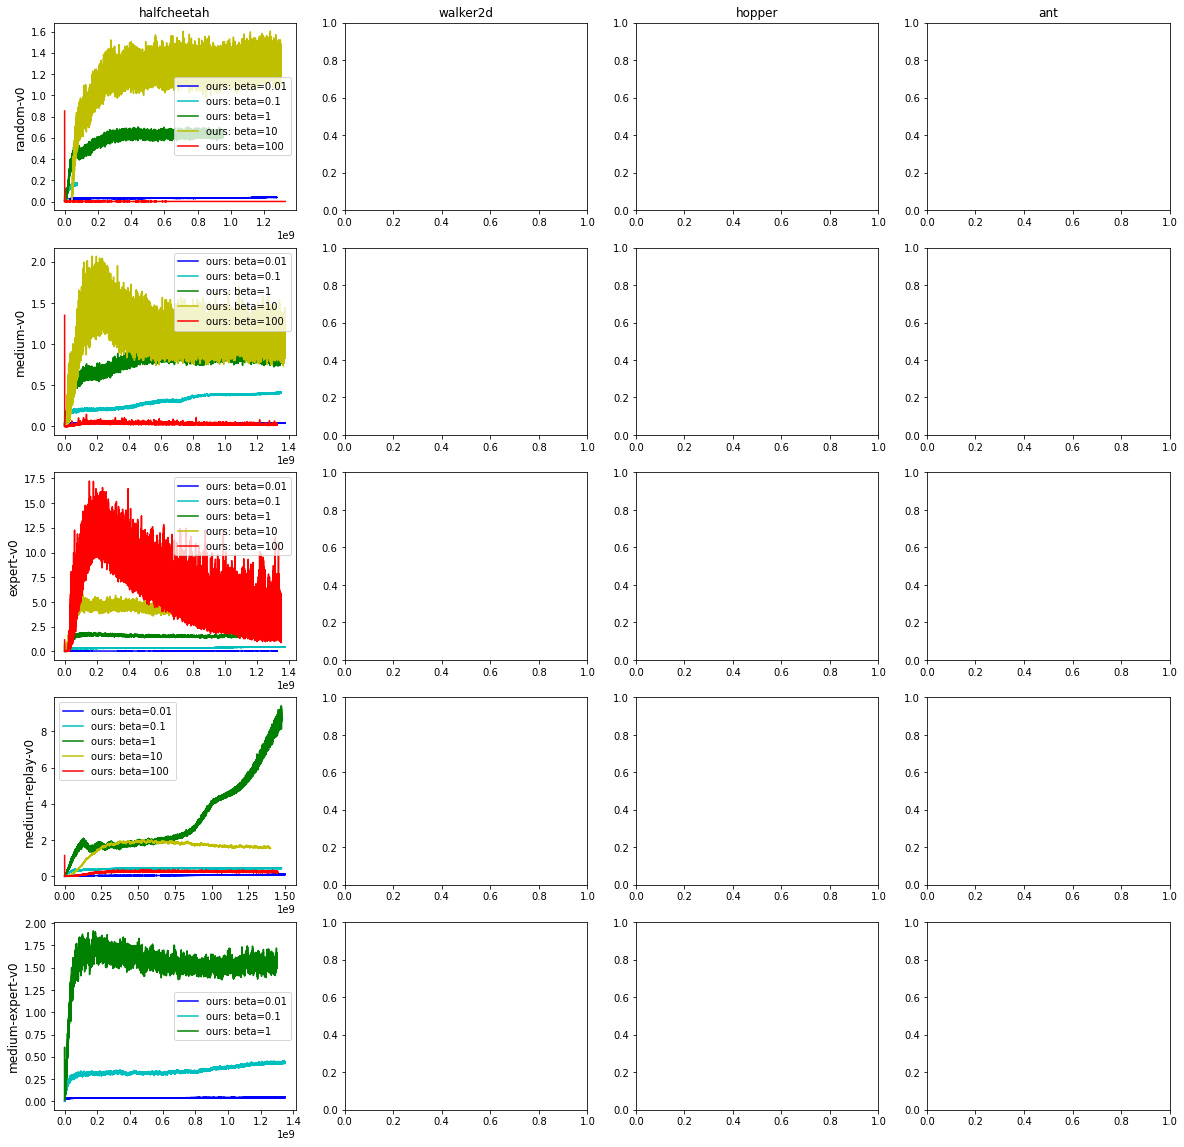

In [17]:
show_hyperparam_sweep("critic_kl_loss", ['ours'], envs, datasets, hp_mapping, colors)

from ours/halfcheetah-random-v0: [17]
num timesteps in array: 17
from ours/halfcheetah-random-v0: [17]
num timesteps in array: 17
from ours/halfcheetah-random-v0: [16]
num timesteps in array: 16
from ours/halfcheetah-random-v0: [17]
num timesteps in array: 17
from ours/halfcheetah-medium-v0: [16]
num timesteps in array: 16
from ours/halfcheetah-medium-v0: [16]
num timesteps in array: 16
from ours/halfcheetah-medium-v0: [17]
num timesteps in array: 17
from ours/halfcheetah-medium-v0: [16]
num timesteps in array: 16
from ours/walker2d-random-v0: [16]
num timesteps in array: 16
from ours/walker2d-random-v0: [17]
num timesteps in array: 17
from ours/walker2d-random-v0: [16]
num timesteps in array: 16
from ours/walker2d-random-v0: [16]
num timesteps in array: 16
from ours/walker2d-medium-v0: [17]
num timesteps in array: 17
from ours/walker2d-medium-v0: [17]
num timesteps in array: 17
from ours/walker2d-medium-v0: [17]
num timesteps in array: 17
from ours/walker2d-medium-v0: [17]
num timeste

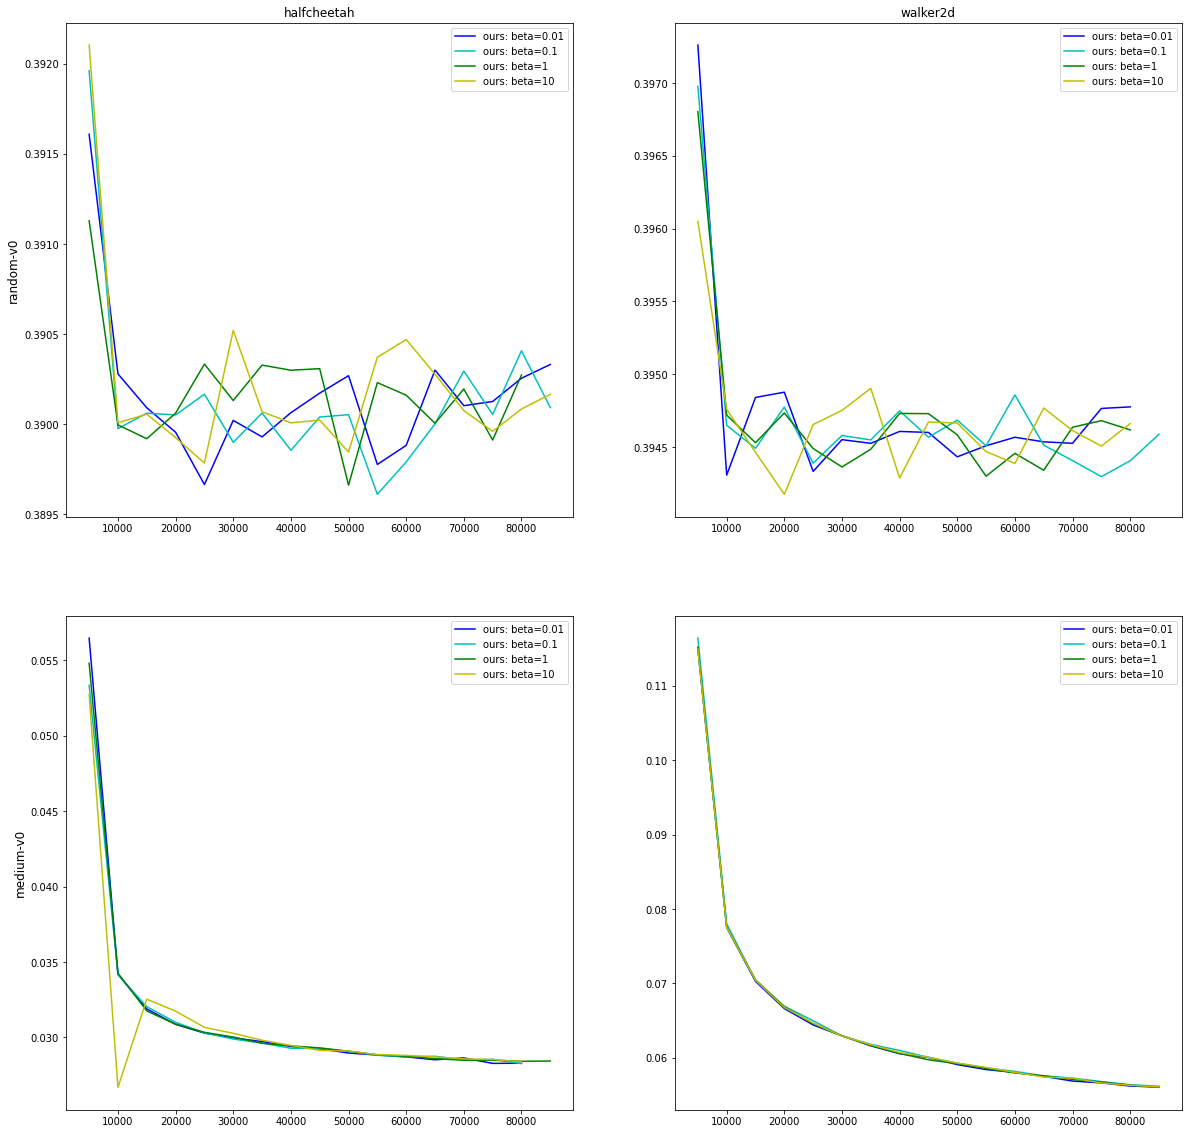

In [30]:
envs = ["halfcheetah", "walker2d"]
datasets = ["random-v0", "medium-v0"]
new_hp_mapping = {'ours': {'beta=0.01': 1985, 'beta=0.1': 1986, 'beta=1': 1987, 'beta=10': 1988}}
show_hyperparam_sweep("reconst_loss", ['ours'], envs, datasets, new_hp_mapping, colors)

In [19]:
latents = get_item_data("latent", 1, 1984, 'ours', 'halfcheetah-expert-v0')

from ours/halfcheetah-expert-v0: [462000000]
num timesteps in array: 77


In [36]:
plt.scatter(latents[0, -1, :, 1], latents[0, -1, :, 2])

NameError: name 'latents' is not defined

from bcq/antmaze-umaze-v0: [200, 200, 79, 0, 200, 0, 0, 0, 0, 0]
num timesteps in array: 0
from ours/antmaze-umaze-v0: [200, 200, 200, 0, 0, 0, 0, 0, 0, 0]
num timesteps in array: 0
from td3_bc/antmaze-umaze-v0: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
num timesteps in array: 0
from td3_bc_vib/antmaze-umaze-v0: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
num timesteps in array: 0
from bcq/antmaze-umaze-diverse-v0: [200, 185, 200, 0, 0, 0, 0, 0, 0, 0]
num timesteps in array: 0
from ours/antmaze-umaze-diverse-v0: [200, 200, 200, 0, 0, 0, 0, 0, 0, 0]
num timesteps in array: 0
from td3_bc/antmaze-umaze-diverse-v0: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
num timesteps in array: 0
from td3_bc_vib/antmaze-umaze-diverse-v0: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
num timesteps in array: 0
from bcq/antmaze-medium-diverse-v0: [190, 183, 196, 0, 0, 0, 0, 0, 0, 0]
num timesteps in array: 0
from ours/antmaze-medium-diverse-v0: [183, 179, 185, 0, 0, 0, 0, 0, 0, 0]
num timesteps in array: 0
from td3_bc/antmaze-medium-diverse-v0: [0, 0, 0, 0

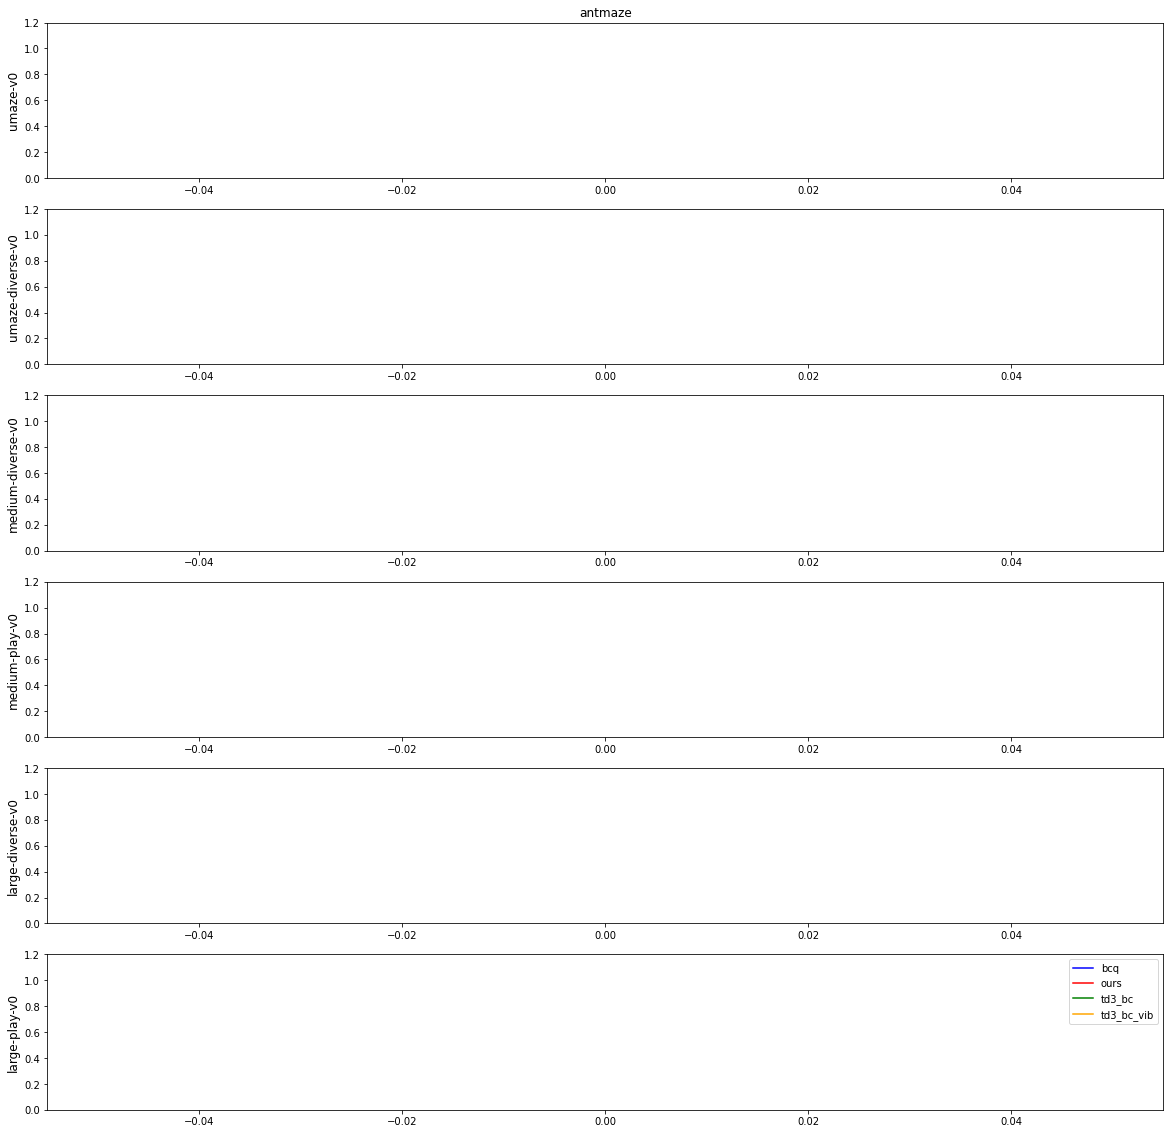

In [40]:
envs = ["antmaze"]
datasets = ["umaze-v0", "umaze-diverse-v0", "medium-diverse-v0", "medium-play-v0", "large-diverse-v0", "large-play-v0"]
programs = ['bcq', 'ours', 'td3_bc', 'td3_bc_vib']
colors = ['blue', 'red', 'green', 'orange', 'yellow', 'purple']
show_programs_and_envs("reward", programs, envs, datasets, 1990, colors=colors, N=10)